<a href="https://colab.research.google.com/github/cristinarainich/MLTSA22_KRainich/blob/main/HW7/HW7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [338]:
import pandas as pd
import numpy as np
import pylab as pl
from scipy import stats 
from scipy.stats import linregress
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel, ExpSineSquared

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [355]:
import warnings
warnings.filterwarnings('ignore')

In [337]:
!pip install george

     |████████████████████████████████| 407 kB 8.6 MB/s 


In [339]:
import george
from george import kernels

## I Data acquisition

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!pip install kaggle

In [4]:
!pwd

/content


In [49]:
cd /content/gdrive/MyDrive/

/content/gdrive/MyDrive


In [50]:
!ls .kaggle

kaggle.json


In [51]:
cd /content/gdrive/MyDrive/.kaggle

/content/gdrive/MyDrive/.kaggle


In [52]:
!chmod 600 kaggle.json

In [53]:
import json
import os
envs = json.load(open("kaggle.json", "r"))
os.environ["KAGGLE_USERNAME"] = envs['username']
os.environ["KAGGLE_KEY"] = envs['key']

In [54]:
os.environ

environ({'CUDNN_VERSION': '8.0.5.39', 'LD_LIBRARY_PATH': '/usr/local/nvidia/lib:/usr/local/nvidia/lib64', 'CLOUDSDK_PYTHON': 'python3', 'LANG': 'en_US.UTF-8', 'HOSTNAME': '5be5bddd5f90', 'OLDPWD': '/', 'CLOUDSDK_CONFIG': '/content/.config', 'NVIDIA_VISIBLE_DEVICES': 'all', 'DATALAB_SETTINGS_OVERRIDES': '{"kernelManagerProxyPort":6000,"kernelManagerProxyHost":"172.28.0.3","jupyterArgs":["--ip=\\"172.28.0.2\\""],"debugAdapterMultiplexerPath":"/usr/local/bin/dap_multiplexer","enableLsp":true}', 'ENV': '/root/.bashrc', 'NCCL_VERSION': '2.7.8', 'TF_FORCE_GPU_ALLOW_GROWTH': 'true', 'NO_GCE_CHECK': 'False', 'PWD': '/', 'HOME': '/root', 'LAST_FORCED_REBUILD': '20220407', 'DEBIAN_FRONTEND': 'noninteractive', 'LIBRARY_PATH': '/usr/local/cuda/lib64/stubs', 'GCE_METADATA_TIMEOUT': '3', 'GLIBCPP_FORCE_NEW': '1', 'TBE_CREDS_ADDR': '172.28.0.1:8008', 'SHELL': '/bin/bash', 'GCS_READ_CACHE_BLOCK_SIZE_MB': '16', 'PYTHONWARNINGS': 'ignore:::pip._internal.cli.base_command', 'CUDA_VERSION': '11.1.1', 'NVID

In [55]:
!mkdir /content/gdrive/MyDrive/MLTSA22/HW7

mkdir: cannot create directory ‘/content/gdrive/MyDrive/MLTSA22/HW7’: File exists


In [56]:
cd /content/gdrive/MyDrive/MLTSA22/HW7

/content/gdrive/MyDrive/MLTSA22/HW7


In [57]:
!pwd

/content/gdrive/MyDrive/MLTSA22/HW7


In [60]:
!kaggle competitions list -s PLAsTiCC-2018

ref                       deadline             category   reward  teamCount  userHasEntered  
------------------------  -------------------  --------  -------  ---------  --------------  
mpetitions/PLAsTiCC-2018  2018-12-17 23:59:00  Featured  $25,000       1089            True  


In [61]:
!kaggle competitions download -c PLAsTiCC-2018

100% 13.8G/13.8G [02:27<00:00, 134MB/s]
100% 13.8G/13.8G [02:27<00:00, 100MB/s]


In [62]:
!ls /content/gdrive/MyDrive/MLTSA22/HW7

PLAsTiCC-2018.zip


In [63]:
!unzip PLAsTiCC-2018.zip

Archive:  PLAsTiCC-2018.zip
  inflating: data_note.pdf           
  inflating: sample_submission.csv   
  inflating: test_set.csv            
  inflating: test_set_batch1.csv     
  inflating: test_set_batch10.csv    
  inflating: test_set_batch11.csv    
  inflating: test_set_batch2.csv     
  inflating: test_set_batch3.csv     
  inflating: test_set_batch4.csv     
  inflating: test_set_batch5.csv     
  inflating: test_set_batch6.csv     
  inflating: test_set_batch7.csv     
  inflating: test_set_batch8.csv     
  inflating: test_set_batch9.csv     
  inflating: test_set_metadata.csv   
  inflating: test_set_sample.csv     
  inflating: training_set.csv        
  inflating: training_set_metadata.csv  


In [73]:
metadata = pd.read_csv('training_set_metadata.csv')
lcvs = pd.read_csv('training_set.csv')

In [68]:
lcvs.head()

,object_id,mjd,passband,flux,flux_err,detected
0,615,59750.4229,2,-544.810303,3.622952,1
1,615,59750.4306,1,-816.434326,5.553370,1
2,615,59750.4383,3,-471.385529,3.801213,1
3,615,59750.4450,4,-388.984985,11.395031,1
4,615,59752.4070,2,-681.858887,4.041204,1


In [74]:
metadata.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


In [71]:
print("The shape of light curves dataset is:", lcvs.shape)

The shape of light curves dataset is: (1421705, 6)


In [72]:
#check missing values
lcvs.isna().sum()

object_id    0
mjd          0
passband     0
flux         0
flux_err     0
detected     0
dtype: int64

In [75]:
bands = lcvs["passband"].unique()
print("Passbands (filter) identifiers:", bands)

Passbands (filter) identifiers: [2 1 3 4 5 0]


In [77]:
objects = lcvs["object_id"].unique()
print("There are {} astrophysical simulated objects in my dataset".format(objects.shape[0]))

There are 7848 astrophysical simulated objects in my dataset


In [78]:
print("The metadata columns are: ", metadata.columns)

The metadata columns are:  Index(['object_id', 'ra', 'decl', 'gal_l', 'gal_b', 'ddf', 'hostgal_specz',
       'hostgal_photoz', 'hostgal_photoz_err', 'distmod', 'mwebv', 'target'],
      dtype='object')


In [79]:
print("The metadata dataset contains features: ", metadata.shape[1])

The metadata dataset contains features:  12


## II Data exploration and visualization

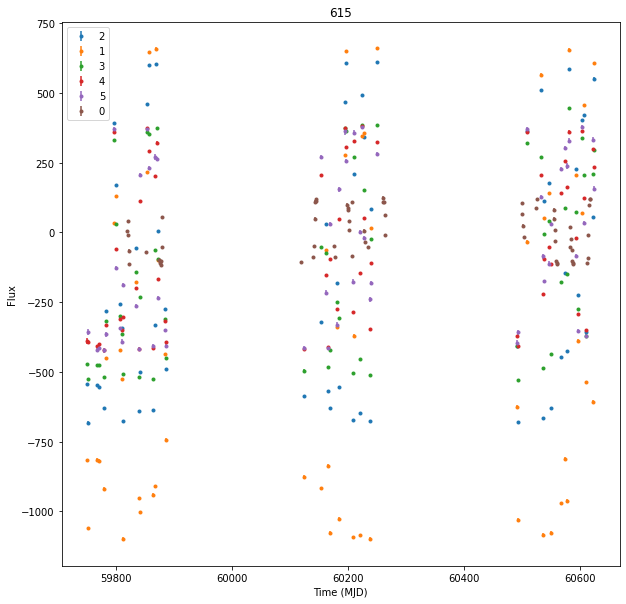

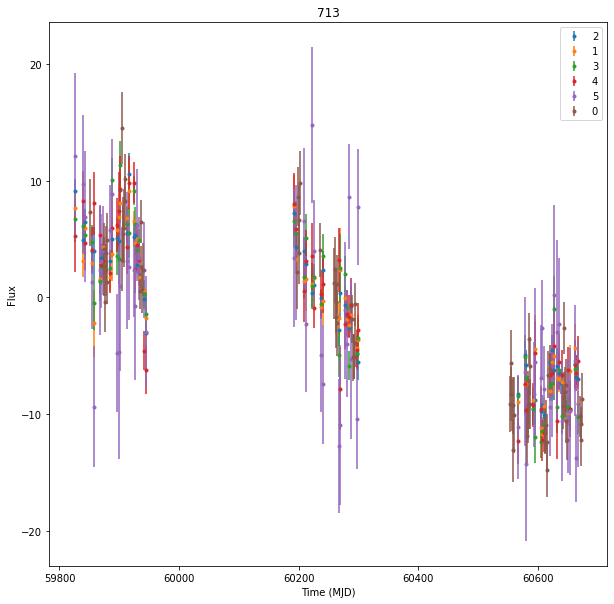

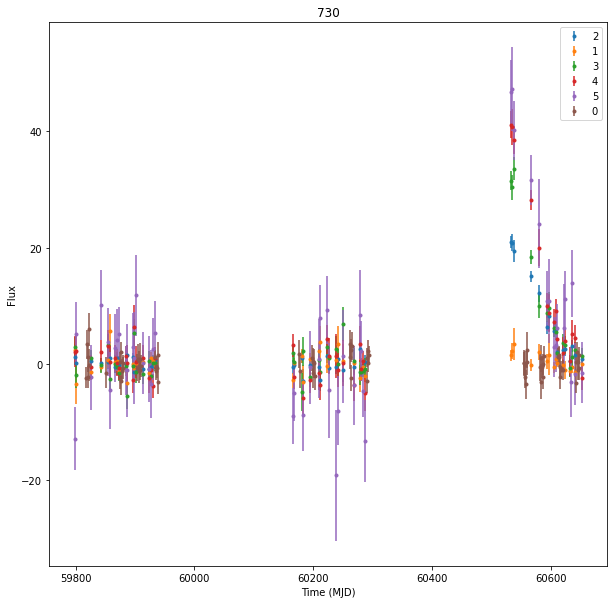

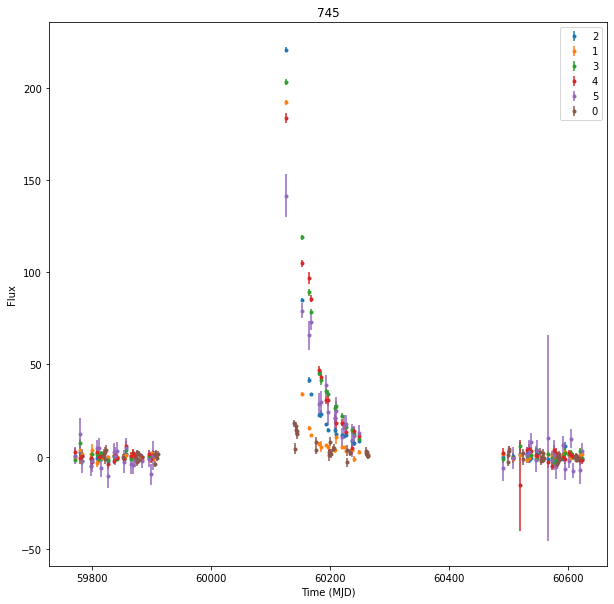

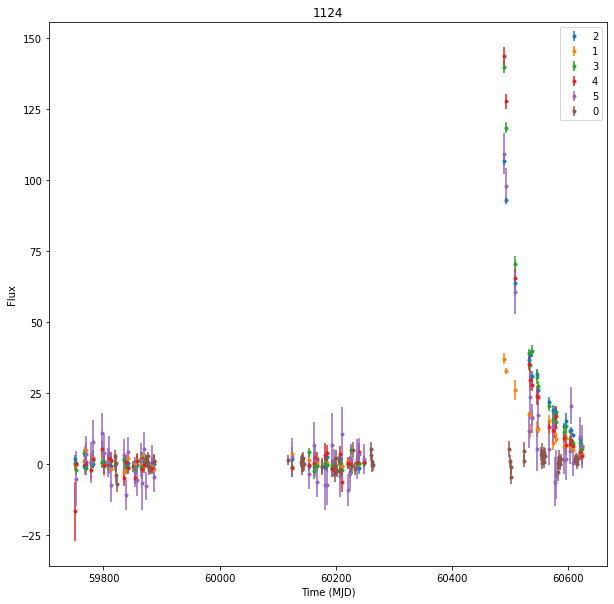

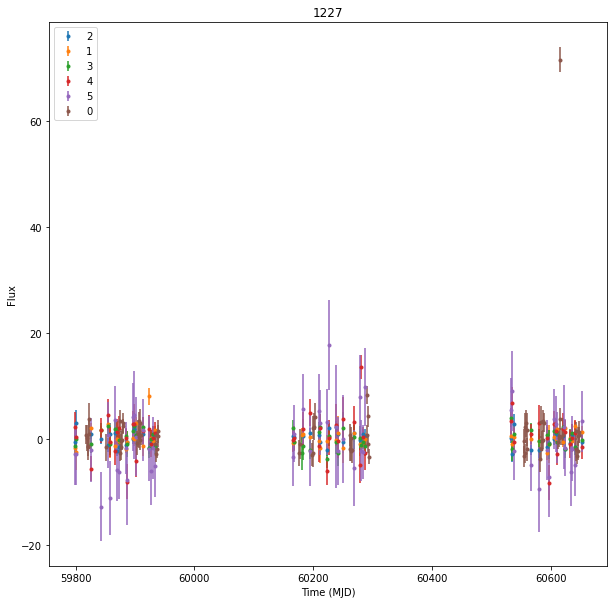

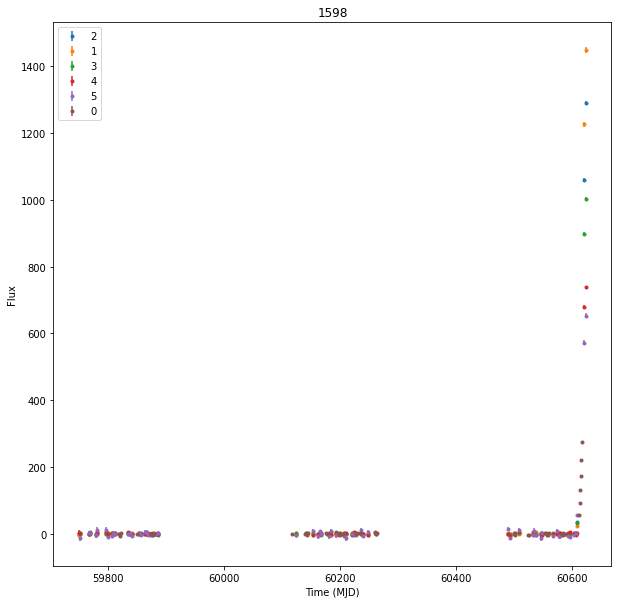

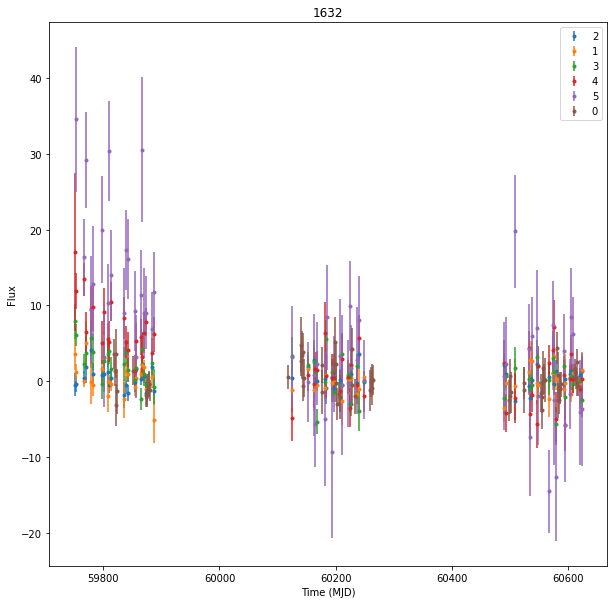

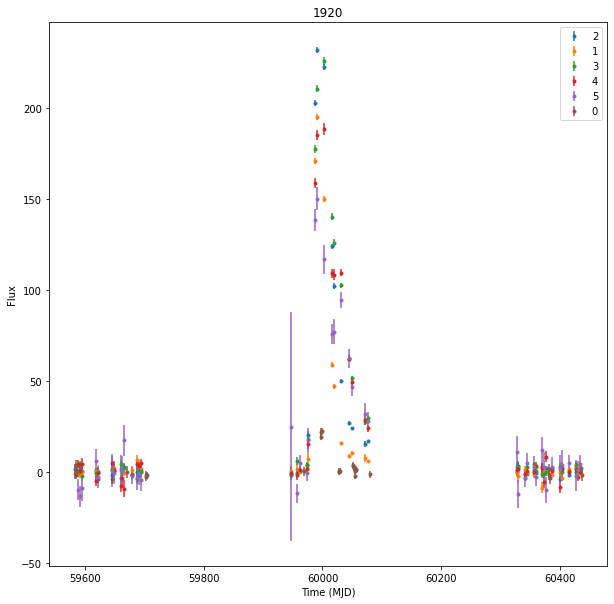

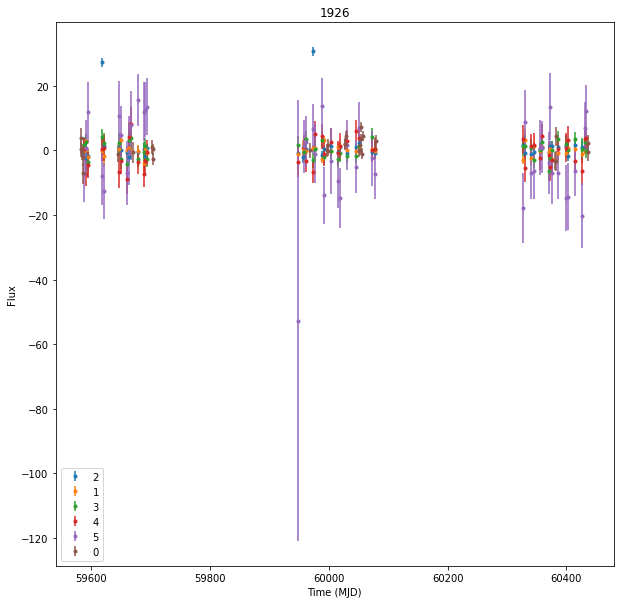

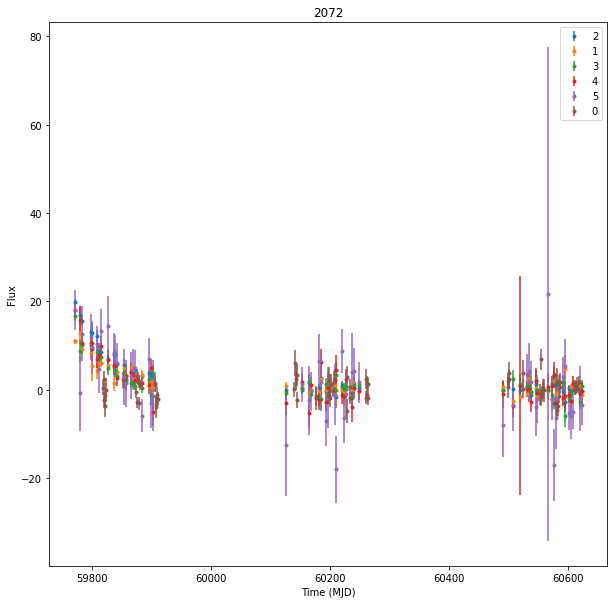

In [376]:
#Plot light curves for 10 objects.
for i in range(0,11):
  pl.figure(figsize=(10,10))
  for j in bands:
    data_ = lcvs[lcvs['object_id'] == objects[i]]
    pl.errorbar(data_['mjd'][data_['passband'] == j], 
            data_['flux'][data_['passband'] == j], 
            yerr = data_['flux_err'][data_['passband'] == j], fmt = '.')
  pl.legend(labels = bands)
  pl.xlabel('Time (MJD)')
  pl.ylabel('Flux')
  pl.title(objects[i]);

**Fig. 1.** The plots of light curves for 10 objects. On x axis, there is the time in Modified Julian Date (MJD) of the observation. On y axis, the measured flux (brightness) in the passband of observation. These values have already been corrected for dust extinction (mwebv). Each band is labeled with different colors. Error bars are also plotted in corresponding colour. Overall, we can see that time series are somewhat 'clustered' around time points which could be related to specificity of telescope measurements. For some of the objects, there is little uncertainty, whereas for others - a lot of outliers with greater uncertainty. For some of the objects, we can also see more or less stable trends across time. For some of them, we could see the 'bursts' of brightness or, in contrast, rapid decrease in brightness. I guess it is tightly connected to the type of the object and the cycle of 'star life' it is currently in.  

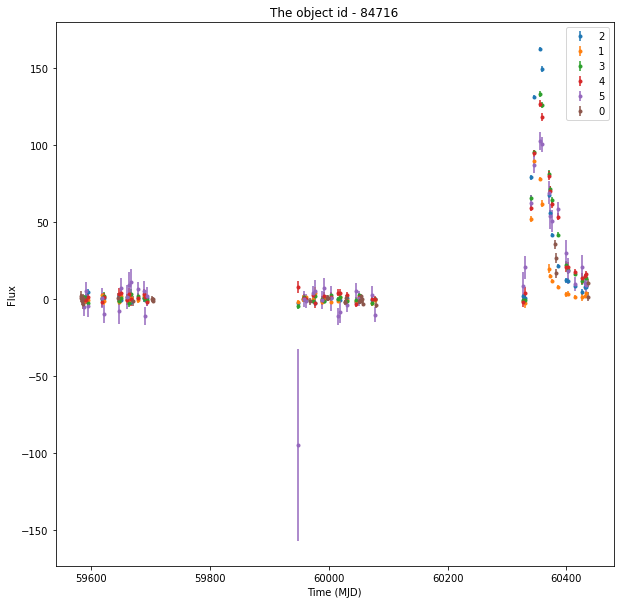

In [193]:
pl.figure(figsize=(10,10))
for j in bands:
  data_ = lcvs[lcvs['object_id'] == 84716]
  pl.errorbar(data_['mjd'][data_['passband'] == j], 
          data_['flux'][data_['passband'] == j], 
          yerr = data_['flux_err'][data_['passband'] == j], 
          fmt='.')
pl.legend(labels = bands)
pl.xlabel('Time (MJD)')
pl.ylabel('Flux')
pl.title('The object id - 84716');

**Fig. 2** The lightcurve for the object #84716. The uncertainties for different measurements not too big (especially compared to some other objects depicted above). However, we can see possibly an outlier with a great error bar. For the first parts of time series, the signal is more stable (or stationary). However, around the time point 60400, there is a rapid increase in brightness of the object. Is it supernova bursting? Who knows..

## III Extract features

**Raw lightcurve features**

From raw time series, I've extracted minimum and maximum values, as they could explain the difference in magnitude in the signal over time and tell more about the brightness pattern of the object throught time. Meaning if a minimum value for an object at particular band was -150 and maximum 150, then there should be a pattern of rapid change in brightness and the object might be less 'stable' compared to others. Min and max are continious variables. In our data they have absolute maximum and minimum.  In theory, I would think that it would be bound by law of physics.

In [157]:
means_raw = lcvs.groupby(["object_id", "passband"])[["flux"]].mean()

In [156]:
stds_raw = lcvs.groupby(["object_id", "passband"])[["flux"]].std()

In [190]:
min_raw = lcvs.groupby(["object_id", "passband"])[["flux"]].min()

In [192]:
max_raw = lcvs.groupby(["object_id", "passband"])[["flux"]].max()

**Standardized lightcurve features**

From this category, I've chosen slope and intercept for each of the objects and bands. It might tell us more about overall trends in brightness change over time, whether it decreases or increases or was more or less non-changeable and what was the starting point of measurement (initial brightness). These are continous variables, unbound.

In [172]:
#standardization of data
standardization = lambda x: (x - x.mean()) / x.std()
lcvs_standard = lcvs.groupby(["object_id", "passband"])[["flux"]].transform(standardization)
lcvserror_standard = (lcvs['flux_err'] - lcvs['flux_err'].mean())/lcvs['flux_err'].std()
lcvs_stand = pd.concat([lcvs_standard,lcvserror_standard, lcvs['object_id'], lcvs['passband'], lcvs['mjd']], axis = 1)

In [322]:
max_stand = lcvs_stand.groupby(["object_id", "passband"])[["flux"]].max()
mean_stand = lcvs_stand.groupby(["object_id", "passband"])[["flux"]].mean()
std_stand = lcvs_stand.groupby(["object_id", "passband"])[["flux"]].std()

In [233]:
lcvs_stand.head()

,flux,flux_err,object_id,passband,mjd
0,-0.902317,-0.005732,615,2,59750.4229
1,-0.715759,-0.005226,615,1,59750.4306
2,-1.044293,-0.005686,615,3,59750.4383
3,-1.141283,-0.003695,615,4,59750.4450
4,-1.203442,-0.005623,615,2,59752.4070


In [234]:
find_slope = lambda v: linregress(v.mjd, v.flux)[0]
slopes = lcvs_stand.groupby(["object_id", "passband"]).apply(find_slope)

In [249]:
slopes

object_id  passband
615        0           0.000524
           1           0.000559
           2           0.000750
           3           0.000908
           4           0.001037
                         ...   
130779836  1          -0.002528
           2          -0.001860
           3          -0.002308
           4          -0.001134
           5          -0.001480
Length: 47088, dtype: float64

In [238]:
find_intercept = lambda v: linregress(v.mjd, v.flux)[1]
intercepts = lcvs_stand.groupby(["object_id", "passband"]).apply(find_intercept)

**Metadata feautures**

Here I've chosen delc = declination, sky coordinate: co-latitude in degrees. Continious variable, bound by the maximum and minimum values for coordinates. The position on the sky could provide additional information about the type or characteristics of the object we are dealing with.

In [242]:
metadata.head()

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90


In [247]:
decl = metadata['decl']

In [377]:
#check if you did it right
print("Mean:", mean_stand)
print("Standard Deviation:", std_stand)

Mean:                             flux
object_id passband              
615       0         4.229421e-17
          1         2.871266e-16
          2         6.891039e-17
          3        -8.422382e-17
          4        -6.508204e-17
...                          ...
130779836 1         3.700743e-17
          2         7.549517e-17
          3         1.160688e-16
          4        -2.775558e-17
          5         5.551115e-17

[47088 rows x 1 columns]
Standard Deviation:                     flux
object_id passband      
615       0          1.0
          1          1.0
          2          1.0
          3          1.0
          4          1.0
...                  ...
130779836 1          1.0
          2          1.0
          3          1.0
          4          1.0
          5          1.0

[47088 rows x 1 columns]


**Merging feature**

In [323]:
#example
features = mean_stand.merge(min_raw, left_index=True, right_index=True, suffixes = ['_mean', '_min'])
features = features.merge(max_raw, left_index=True, right_index=True)
features = features.merge(std_stand, left_index=True, right_index=True)
features = features.merge(slopes.to_frame(), left_index=True, right_index=True)
features = features.merge(intercepts.to_frame(), left_index=True, right_index=True)


In [324]:
features.columns

Index(['flux_mean', 'flux_min', 'flux_x', 'flux_y', '0_x', '0_y'], dtype='object')

In [325]:
features = features.rename(columns = {'flux_mean':'mean_stand', 'flux_min':'min_raw', 'flux_x':'max_raw',
                 'flux_y':'std_stand', '0_x':'slopes', '0_y':'intercepts'})

In [326]:
features.head()

mean_stand      min_raw     max_raw  std_stand  \
object_id passband                                                     
615       0         4.229421e-17  -116.913223  125.182808        1.0   
          1         2.871266e-16 -1100.440063  660.626343        1.0   
          2         6.891039e-17  -681.858887  611.984558        1.0   
          3        -8.422382e-17  -530.644592  445.737061        1.0   
          4        -6.508204e-17  -422.184509  381.953735        1.0   

                      slopes  intercepts  
object_id passband                        
615       0         0.000524  -31.568270  
          1         0.000559  -33.627702  
          2         0.000750  -45.105485  
          3         0.000908  -54.614313  
          4         0.001037  -62.397784

In [327]:
allfeatures = features.reset_index().set_index(['object_id','passband']).stack(
    ).unstack([1,2])

In [328]:
allfeatures['decl'] = decl

In [329]:
allfeatures.head()

passband              0                                              \
             mean_stand     min_raw     max_raw std_stand    slopes   
object_id                                                             
615        4.229421e-17 -116.913223  125.182808       1.0  0.000524   
713        3.806479e-17  -14.735178   14.509829       1.0 -0.002859   
730       -7.709882e-18   -3.459960    5.942166       1.0 -0.000121   
745       -1.079383e-16   -3.874349   18.014029       1.0 -0.000700   
1124       3.524518e-18   -6.804703    5.330927       1.0  0.001234   

passband                          1                                     ...  \
           intercepts    mean_stand      min_raw     max_raw std_stand  ...   
object_id                                                               ...   
615        -31.568270  2.871266e-16 -1100.440063  660.626343       1.0  ...   
713        172.455472  1.586033e-17   -11.715749    9.129021       1.0  ...   
730          7.289630 -1.120898e-17    -3.393080    5.693109       1.0  ...   
745         42.151725  2.725994e-17    -3.618410  192.244293       1.0  ...   
1124       -74.410211 -6.938894e-17    -2.622109   37.170177       1.0  ...   

passband          4                                   5              \
          std_stand    slopes  intercepts    mean_stand     min_raw   
object_id                                                             
615             1.0  0.001037  -62.397784 -9.738798e-18 -422.815094   
713             1.0 -0.002681  161.531278 -1.189525e-17  -14.211164   
730             1.0  0.001477  -88.965827  4.789197e-17  -19.159811   
745             1.0 -0.000108    6.494881 -1.312082e-17  -10.249387   
1124            1.0  0.001344  -80.863243 -1.292825e-16  -10.860540   

passband                                                    decl  
              max_raw std_stand    slopes  intercepts             
object_id                                                         
615        378.188141       1.0  0.001003  -60.370675 -28.291550  
713         14.770886       1.0 -0.001978  119.182082   3.583322  
730         47.310059       1.0  0.001259  -75.802184   3.583322  
745        141.513290       1.0  0.000003   -0.159352   2.985506  
1124       109.157585       1.0  0.001110  -66.832942   3.732834  

[5 rows x 37 columns]

In [330]:
print("My feature space is {} features (columns)".format(allfeatures.shape[1]))

My feature space is 37 features (columns)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


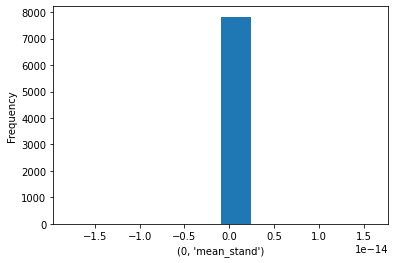

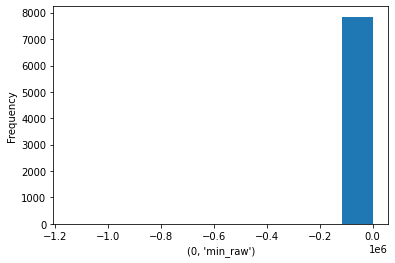

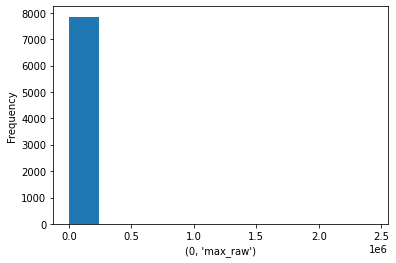

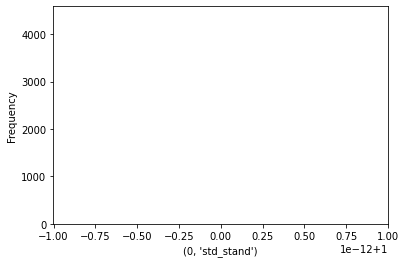

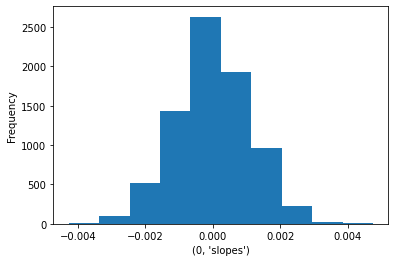

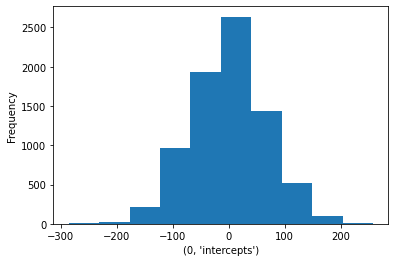

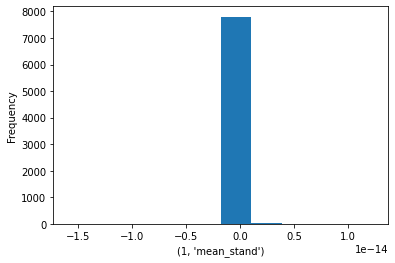

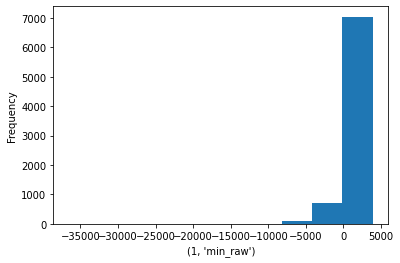

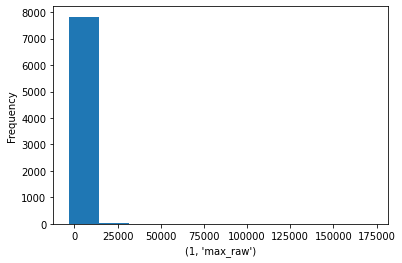

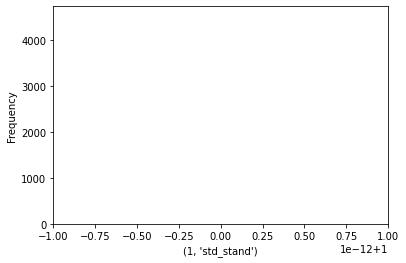

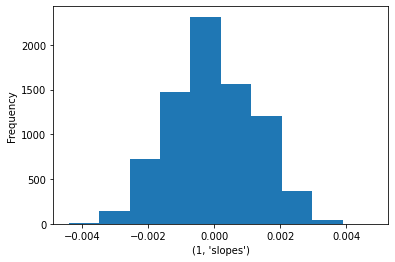

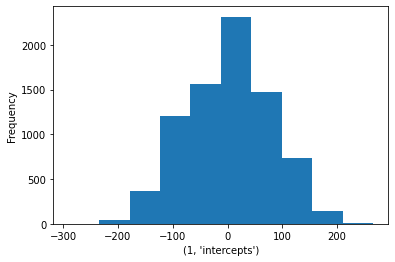

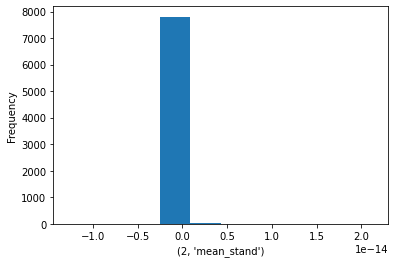

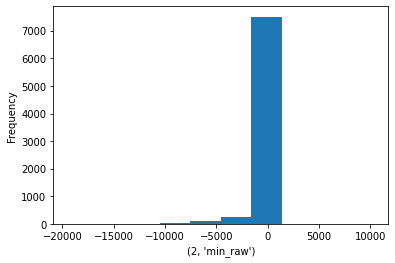

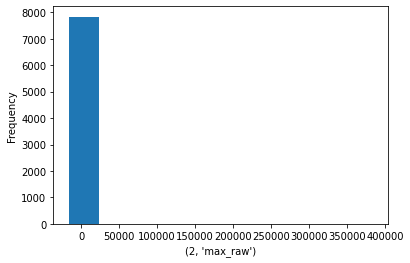

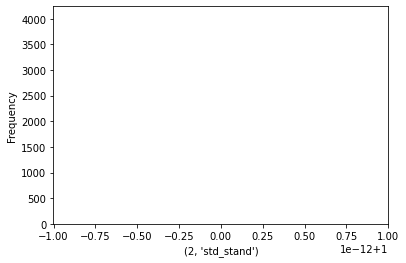

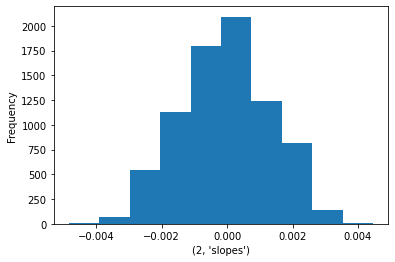

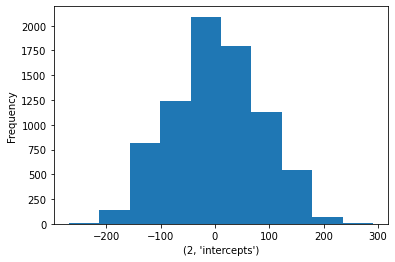

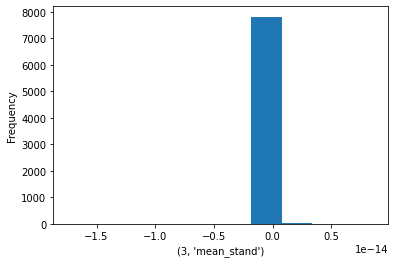

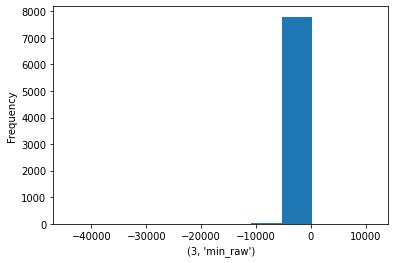

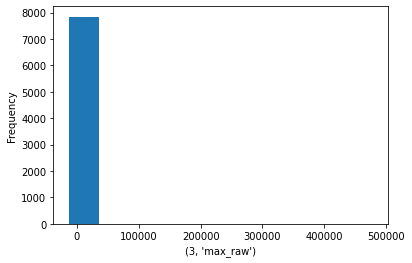

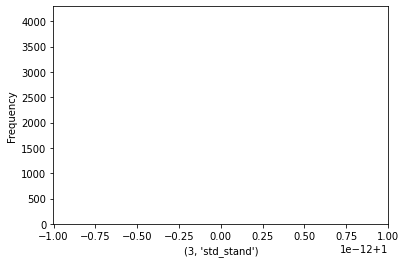

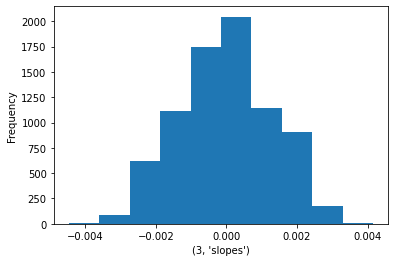

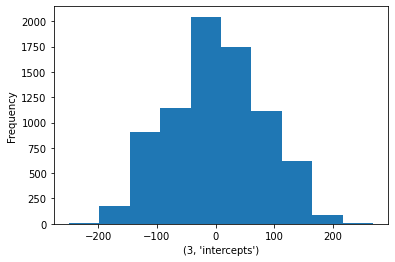

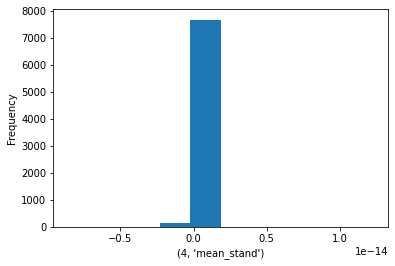

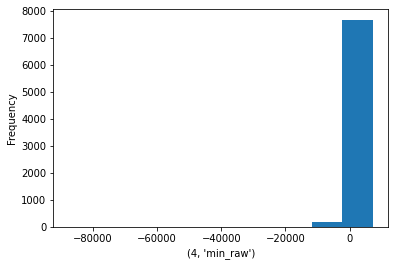

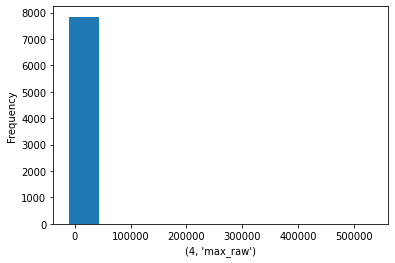

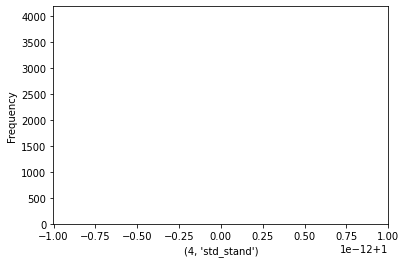

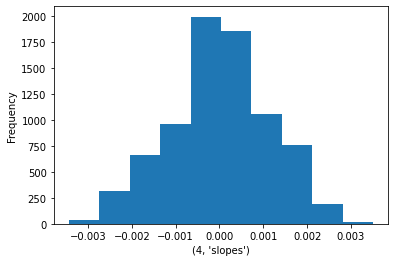

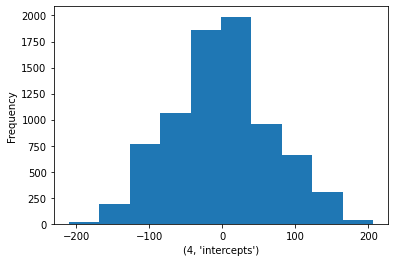

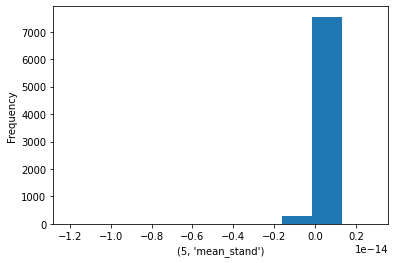

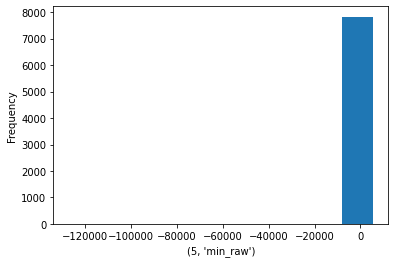

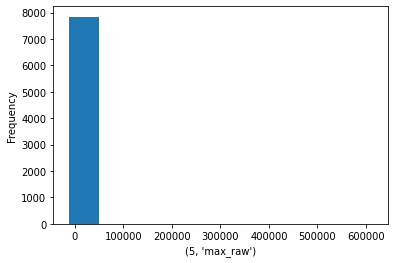

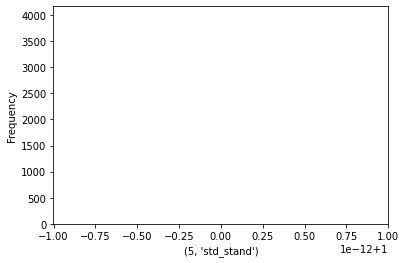

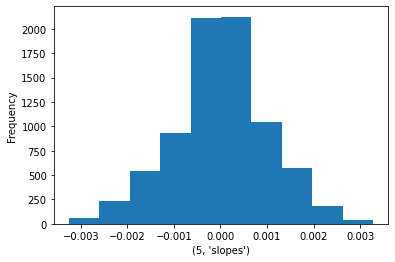

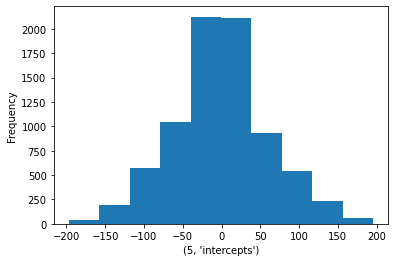

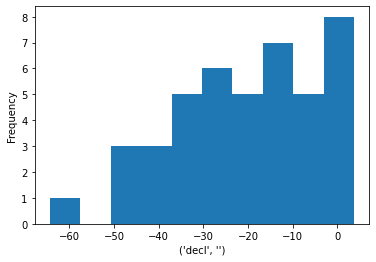

In [331]:
for i in allfeatures.columns:
  pl.figure()
  pl.hist(allfeatures[i])
  pl.xlabel(i)
  pl.ylabel('Frequency');

**Fig. 3.** The histograms for distributions of each feature in each of the bands. Min and max of time series have skewed distributions as expected. Intercepts and slops kinds follow normal distribution. Decl fearure has an interesting distrubution with a slight skewness towards 0. Worth mentioning that decl hasn't been mapped on diffferent bands.

## III Gaussian Processes

In [334]:
lcvs_stand.head()

,flux,flux_err,object_id,passband,mjd
0,-0.902317,-0.005732,615,2,59750.4229
1,-0.715759,-0.005226,615,1,59750.4306
2,-1.044293,-0.005686,615,3,59750.4383
3,-1.141283,-0.003695,615,4,59750.4450
4,-1.203442,-0.005623,615,2,59752.4070


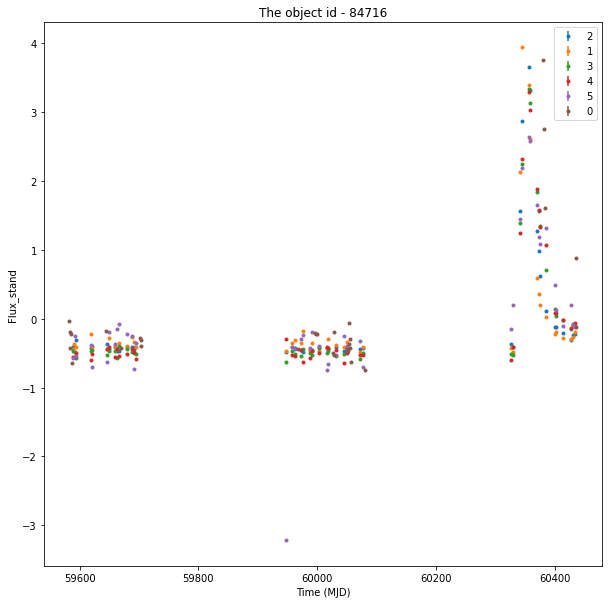

In [335]:
pl.figure(figsize=(10,10))
for j in bands:
  data_ = lcvs_stand[lcvs_stand['object_id'] == 84716]
  pl.errorbar(data_['mjd'][data_['passband'] == j], 
          data_['flux'][data_['passband'] == j], 
          yerr = data_['flux_err'][data_['passband'] == j], 
          fmt='.')
pl.legend(labels = bands)
pl.xlabel('Time (MJD)')
pl.ylabel('Flux_stand')
pl.title('The object id - 84716');

**Fig. 4.** The standardized lightcurve of the object 84716.

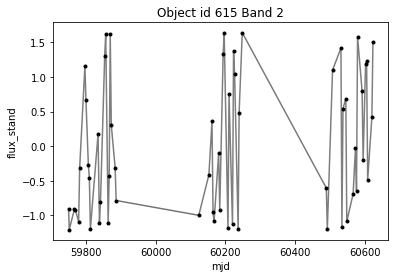

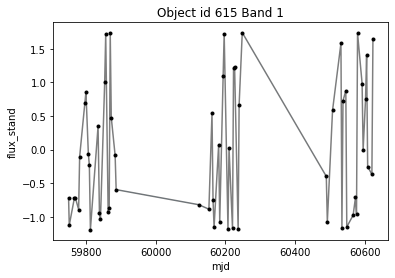

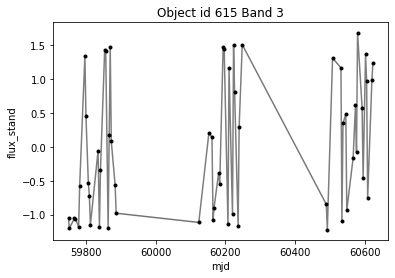

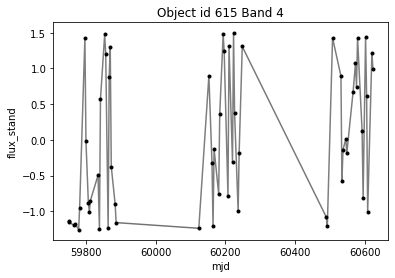

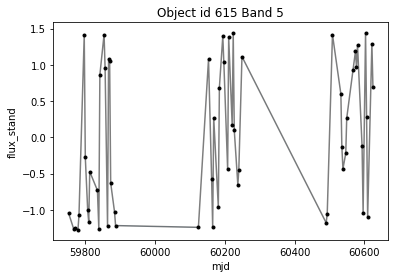

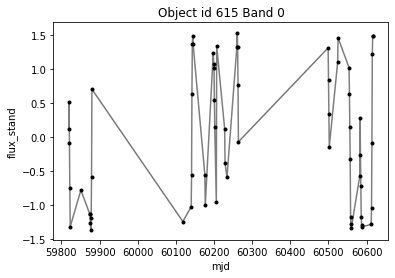

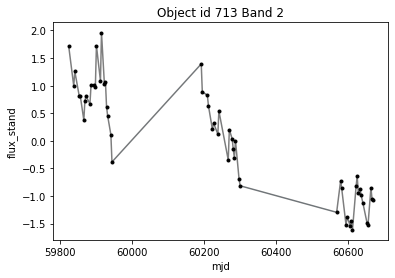

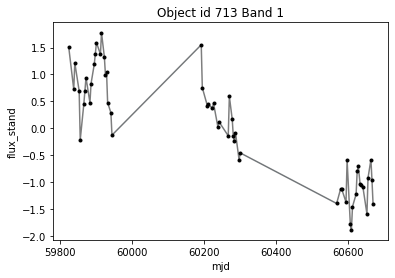

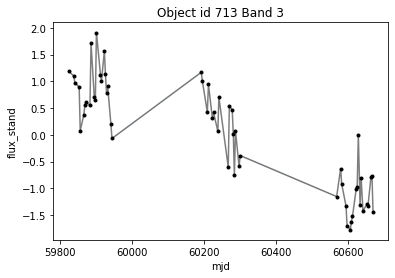

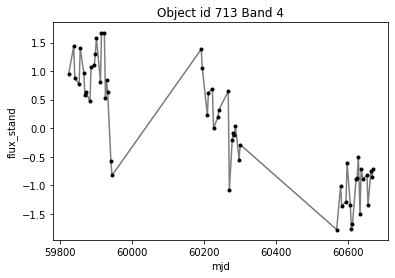

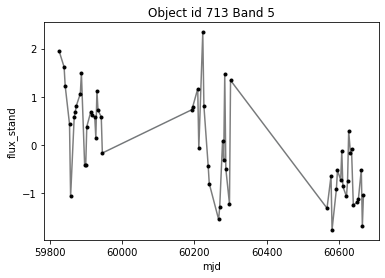

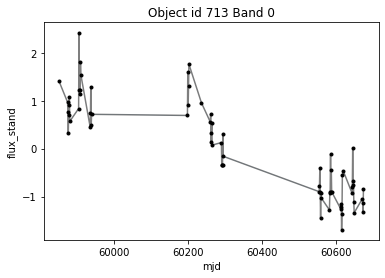

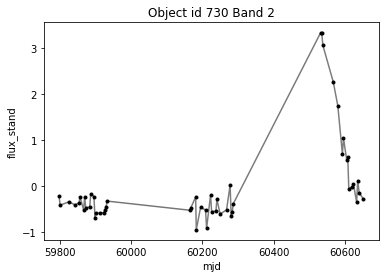

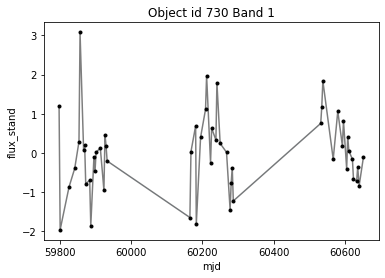

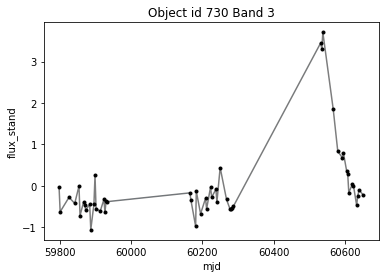

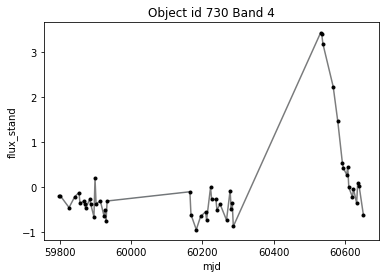

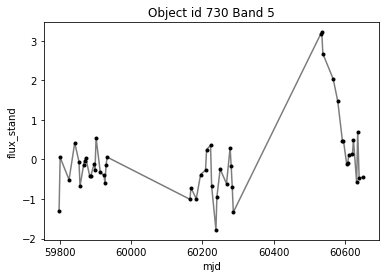

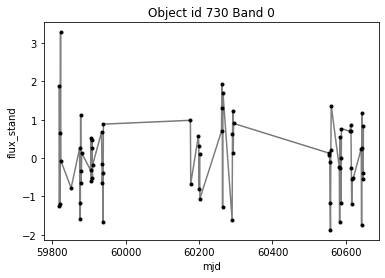

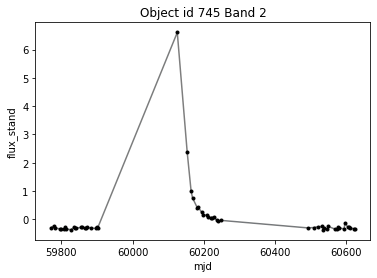

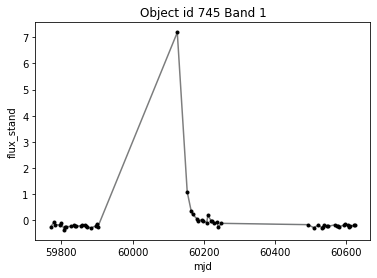

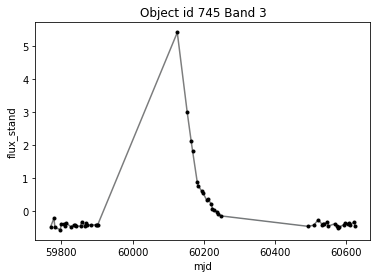

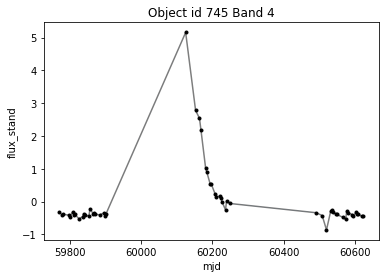

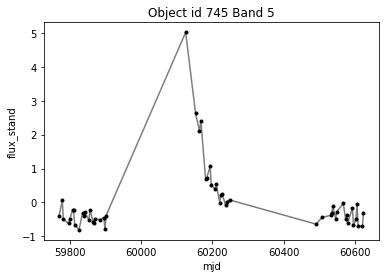

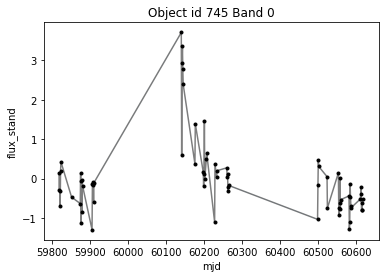

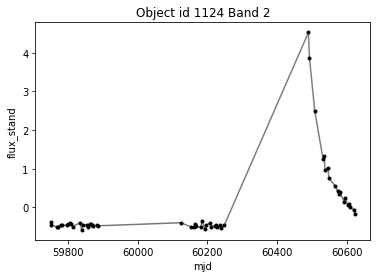

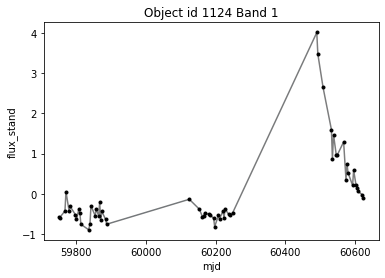

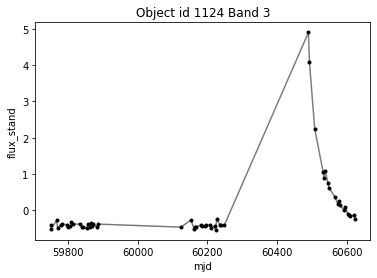

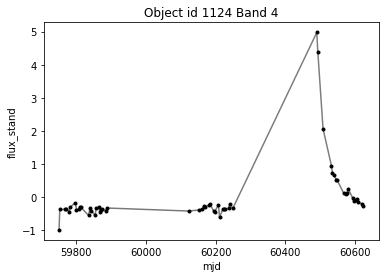

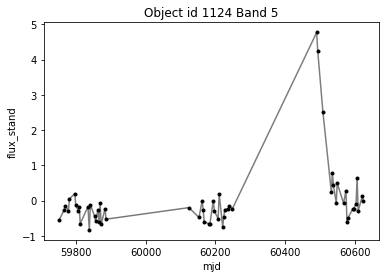

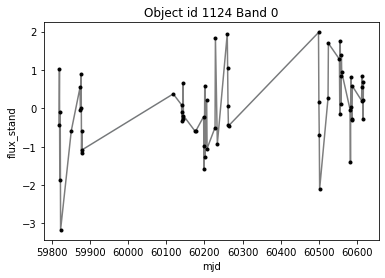

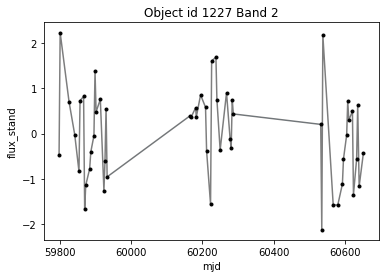

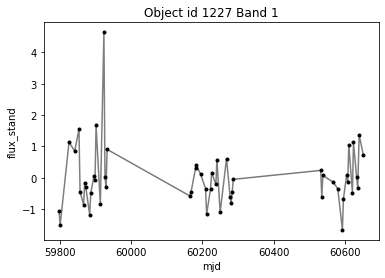

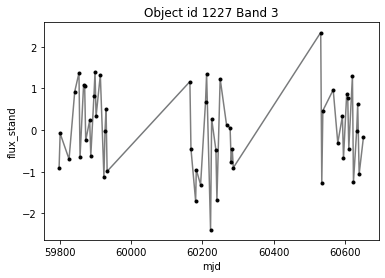

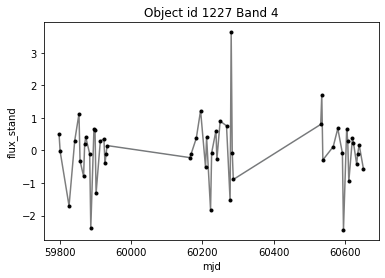

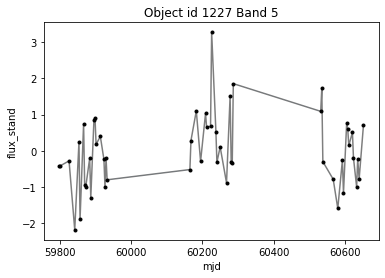

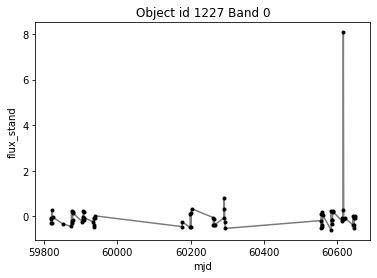

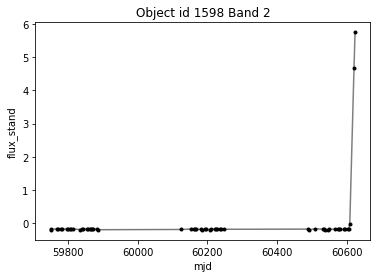

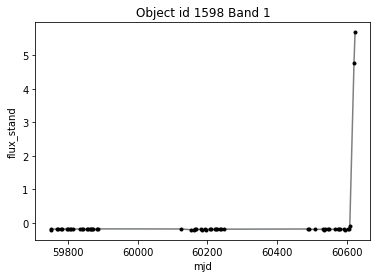

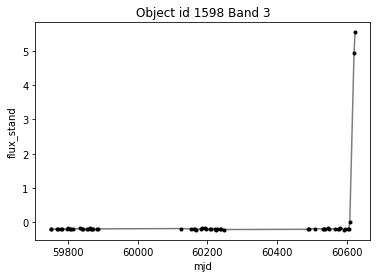

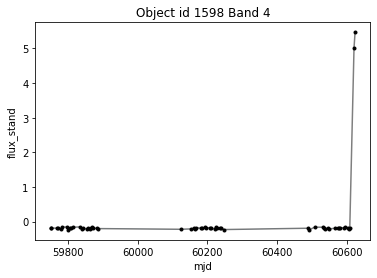

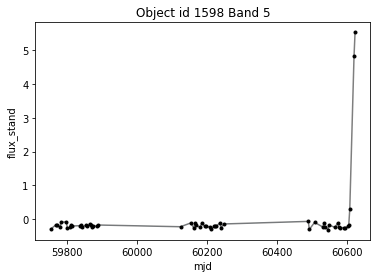

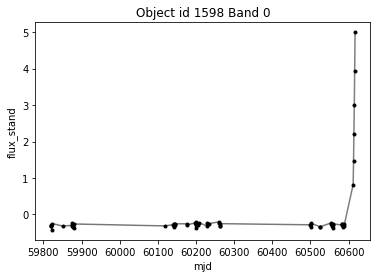

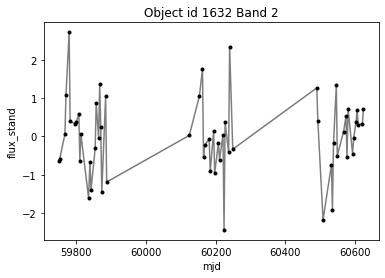

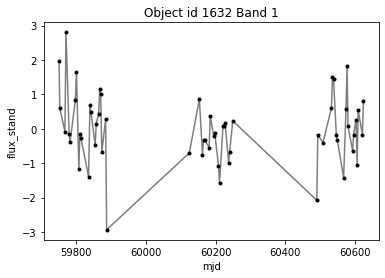

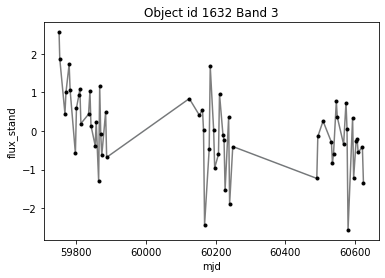

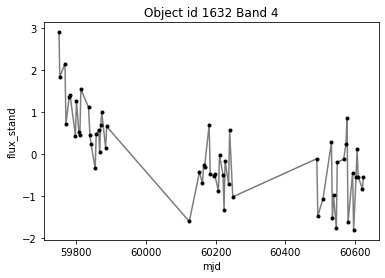

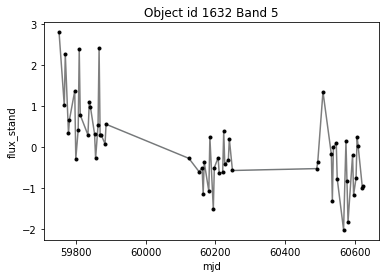

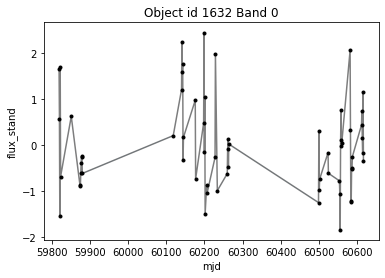

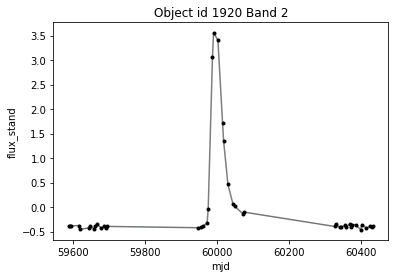

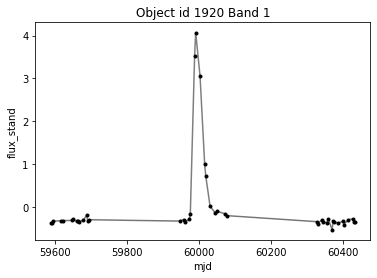

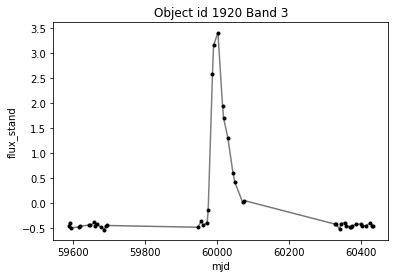

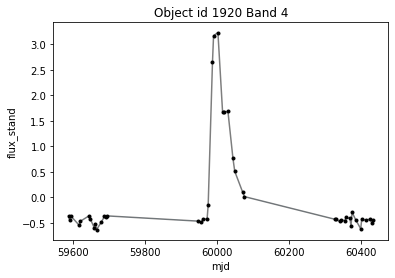

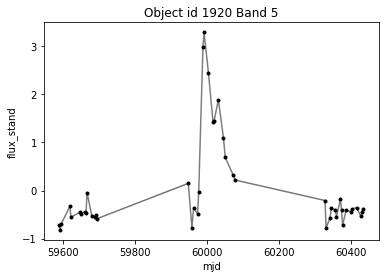

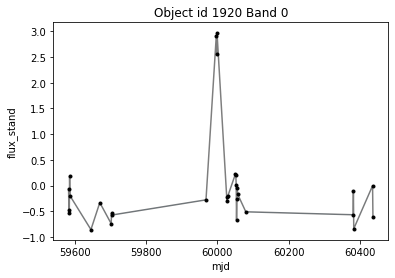

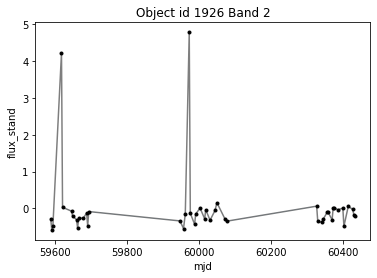

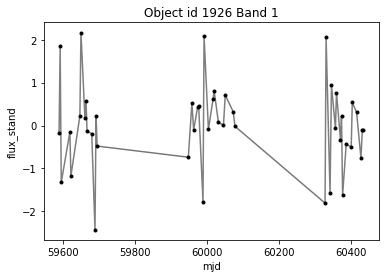

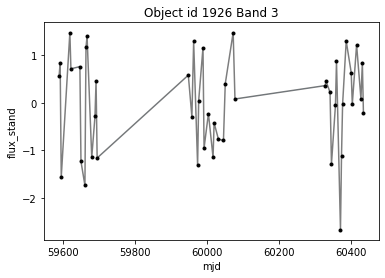

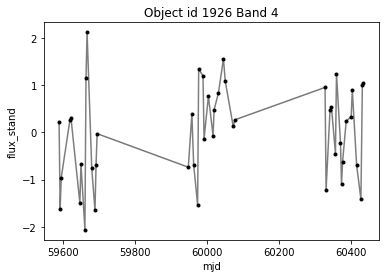

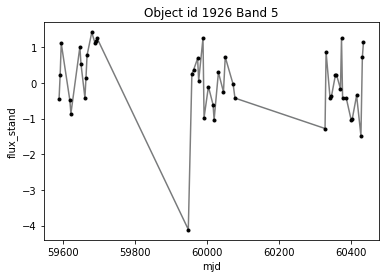

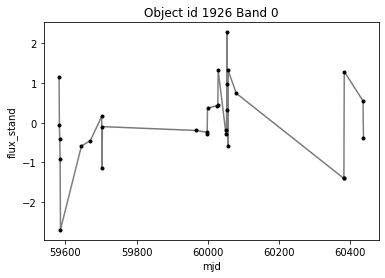

In [374]:
parameters = {}
y = lcvs_stand['flux']
kernel = np.var(y) * kernels.Product(kernels.ExpSquaredKernel(0.5), 
                                     kernels.CosineKernel(1))
for obj in objects[:10]:
  for band in bands:
    gp = george.GP(kernel)
    subset = lcvs_stand[lcvs_stand['object_id'] == obj][lcvs_stand['passband'] == band]
    t = subset['mjd']
    y = subset['flux']
    yerr = subset['flux_err']
    t_pred = np.atleast_2d(subset['mjd']).T

    gp.compute(t, yerr)
    pred, pred_var = gp.predict(y, t_pred, return_var=True)
    parameters['Object id ' + str(obj) + ' Band ' + str(band)] = str(gp.get_parameter_vector()), str(gp.log_likelihood(y)), str(np.var(y))
   
    pl.figure()
    pl.fill_between(t_pred.ravel(), pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                alpha=0.2)
    pl.plot(t_pred.ravel(), pred, "k", lw=1.5, alpha=0.5)
    pl.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
    pl.xlabel("mjd")
    pl.ylabel("flux_stand")
    pl.title('Object id ' + str(obj) + ' Band ' + str(band))

**Fig. 5.** For 10 objects from the data, using Gaussian processing from george package we made predictions incorporating prior
knowledge (kernels) and provided uncertainty measures over predictions (which are not seen here). I'm not sure why my graphs are not like the ones we did in class (maybe it's because data is standardized). 

The data is standardized, so the variance is 1.  Parameters are mostly identical, they differ a little. I guess using the same kernel might be fine and it allows easily to compare the result. However for some object, we would need less complicated kernels to avoid overfitting, and more complicated ones when it fails to represend the data. 
how would you initialize the fit for the whole ensamble? Divide it in the groupd depending on exctracted features and try to use different kernels for each group?

In [375]:
parameters

{'Object id 1124 Band 0': ('[-0.03368171 -0.69314718  1.        ]',
  '-92.36033968887057',
  '0.9841269841269839'),
 'Object id 1124 Band 1': ('[-0.03368171 -0.69314718  1.        ]',
  '-81.79510521218761',
  '0.9827586206896548'),
 'Object id 1124 Band 2': ('[-0.03368171 -0.69314718  1.        ]',
  '-81.79433774769575',
  '0.9827586206896551'),
 'Object id 1124 Band 3': ('[-0.03368171 -0.69314718  1.        ]',
  '-81.79476766613654',
  '0.9827586206896548'),
 'Object id 1124 Band 4': ('[-0.03368171 -0.69314718  1.        ]',
  '-81.7952530349678',
  '0.9827586206896556'),
 'Object id 1124 Band 5': ('[-0.03368171 -0.69314718  1.        ]',
  '-80.37593152077285',
  '0.9824561403508774'),
 'Object id 1227 Band 0': ('[-0.03368171 -0.69314718  1.        ]',
  '-105.70232578961918',
  '0.9861111111111112'),
 'Object id 1227 Band 1': ('[-0.03368171 -0.69314718  1.        ]',
  '-73.28416018094498',
  '0.9807692307692305'),
 'Object id 1227 Band 2': ('[-0.03368171 -0.69314718  1.        